In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings

In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
# Load preprocessed data
tr_features = pd.read_csv('./DATASET/train_features.csv')
tr_labels = pd.read_csv('./DATASET/train_labels.csv')
val_features = pd.read_csv('./DATASET/val_features.csv')
val_labels = pd.read_csv('./DATASET/val_labels.csv')
test_features = pd.read_csv('./DATASET/test_features.csv')
test_labels = pd.read_csv('./DATASET/test_labels.csv')

In [4]:
# Prepare data for PyTorch
X_train = torch.tensor(tr_features.values, dtype=torch.float32) # convert to something PyTorch can work with
y_train = torch.tensor(tr_labels.values, dtype=torch.float32).squeeze() 
X_val = torch.tensor(val_features.values, dtype=torch.float32)
y_val = torch.tensor(val_labels.values, dtype=torch.float32).squeeze()
X_test = torch.tensor(test_features.values, dtype=torch.float32)
y_test = torch.tensor(test_labels.values, dtype=torch.float32).squeeze()

train_dataset = TensorDataset(X_train, y_train) # create datset to feed into the dataloader for training
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

In [5]:
class Model(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, dropout_rate, activation_fn=nn.ReLU):
        super(Model, self).__init__()
        self.input_layer = nn.Linear(in_size, hidden_size)
        self.hidden_activation = activation_fn()  # Activation function is now flexible
        self.dropout = nn.Dropout(p=dropout_rate)
        self.output_layer = nn.Linear(hidden_size, out_size)
    
    def forward(self, inputs):
        x = self.input_layer(inputs)
        x = self.hidden_activation(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return x


# Functions
Using functions to reduce repetitive code.

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=5):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0  # counter for early stopping

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # Check for improvement, if none, do stop early
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping triggered at epoch {epoch+1}")
            break

    # Load the best model weights before returning
    model.load_state_dict(best_model_state)
    return train_losses, val_losses

In [7]:
def find_best_parameters(param_grid, input_size, train_loader, val_loader):
    best_params = None
    best_val_loss = float('inf')

    param_list = list(ParameterGrid(param_grid))
    total_iterations = len(param_list)
    print(f"Starting parameter search over {total_iterations} combinations...")

    for idx, params in enumerate(param_list):
        print(f"Iteration {idx + 1}/{total_iterations}: Testing parameters {params}")
        model = Model(
            in_size=input_size,
            hidden_size=params['hidden_size'],
            out_size=1,
            dropout_rate=params['dropout_rate']
        )
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

        _, val_losses = train_model(
            model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5
        )

        final_val_loss = val_losses[-1]

        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_params = params

        print(f"Iteration {idx + 1}/{total_iterations} completed. Validation Loss: {final_val_loss:.4f}")

    print("Parameter search completed.")
    return best_params

In [8]:
# Hyperparameter Tuning

In [9]:
param_grid = {
    'hidden_size': [32, 64, 128],
    'dropout_rate': [0.3, 0.5, 0.7],
    'learning_rate': [0.001, 0.0005],
    'weight_decay': [1e-5, 1e-4],
    'activation_fn': [nn.ReLU, nn.Sigmoid, nn.Tanh]
}

# Find best parameters
best_params = find_best_parameters(param_grid, X_train.shape[1], train_loader, val_loader)
print("Best Parameters:", best_params)

Starting parameter search over 108 combinations...
Iteration 1/108: Testing parameters {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.3, 'hidden_size': 32, 'learning_rate': 0.001, 'weight_decay': 1e-05}
Epoch [1/50], Training Loss: 0.0674, Validation Loss: 0.0371
Epoch [2/50], Training Loss: 0.0428, Validation Loss: 0.0297
Epoch [3/50], Training Loss: 0.0389, Validation Loss: 0.0268
Epoch [4/50], Training Loss: 0.0366, Validation Loss: 0.0248
Epoch [5/50], Training Loss: 0.0349, Validation Loss: 0.0233
Epoch [6/50], Training Loss: 0.0332, Validation Loss: 0.0254
Epoch [7/50], Training Loss: 0.0348, Validation Loss: 0.0244
Epoch [8/50], Training Loss: 0.0333, Validation Loss: 0.0244
Epoch [9/50], Training Loss: 0.0334, Validation Loss: 0.0243
Epoch [10/50], Training Loss: 0.0323, Validation Loss: 0.0220
Epoch [11/50], Training Loss: 0.0349, Validation Loss: 0.0221
Epoch [12/50], Training Loss: 0.0308, Validation Loss: 0.0238
Epoch [13/50], Training Loss:

# Train the best model

In [10]:
model = Model(
    in_size=X_train.shape[1],
    hidden_size=best_params['hidden_size'],
    out_size=1,
    dropout_rate=best_params['dropout_rate'],
    activation_fn=best_params['activation_fn']
)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])

num_epochs = 50
patience = 50
train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=patience
)


Epoch [1/50], Training Loss: 0.0876, Validation Loss: 0.0473
Epoch [2/50], Training Loss: 0.0511, Validation Loss: 0.0353
Epoch [3/50], Training Loss: 0.0436, Validation Loss: 0.0304
Epoch [4/50], Training Loss: 0.0398, Validation Loss: 0.0279
Epoch [5/50], Training Loss: 0.0357, Validation Loss: 0.0269
Epoch [6/50], Training Loss: 0.0354, Validation Loss: 0.0242
Epoch [7/50], Training Loss: 0.0332, Validation Loss: 0.0233
Epoch [8/50], Training Loss: 0.0327, Validation Loss: 0.0230
Epoch [9/50], Training Loss: 0.0319, Validation Loss: 0.0225
Epoch [10/50], Training Loss: 0.0308, Validation Loss: 0.0230
Epoch [11/50], Training Loss: 0.0304, Validation Loss: 0.0211
Epoch [12/50], Training Loss: 0.0295, Validation Loss: 0.0206
Epoch [13/50], Training Loss: 0.0291, Validation Loss: 0.0203
Epoch [14/50], Training Loss: 0.0291, Validation Loss: 0.0205
Epoch [15/50], Training Loss: 0.0276, Validation Loss: 0.0200
Epoch [16/50], Training Loss: 0.0285, Validation Loss: 0.0213
Epoch [17/50], Tr

# Save the model

In [11]:
model_data = {
    'model_state_dict': model.state_dict(),
    'best_params': best_params,
    'input_size': X_train.shape[1],
    'hidden_size': best_params['hidden_size'],
    'dropout_rate': best_params['dropout_rate'],
}

joblib.dump(model_data, './MLP_model.pkl')
print("Model saved as MLP_model.pkl")

Model saved as MLP_model.pkl


# Evaluation

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, data_loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).squeeze()
            predictions = (probs >= 0.5).float()
            y_true.extend(labels.tolist())
            y_pred.extend(predictions.tolist())
            y_prob.extend(probs.tolist())
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, auc, precision, recall, f1

In [13]:
test_accuracy, test_auc, test_precision, test_recall, test_f1 = evaluate_model(model, test_loader)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.8091
Test AUC: 0.9461
Test Precision: 0.9654
Test Recall: 0.6893
Test F1 Score: 0.8043


In [14]:
with torch.no_grad():
    y_eval = model.forward(X_test)
    loss = criterion(y_eval, y_test.unsqueeze(1))

print(f'Test Loss: {loss.item():.4f}')

Test Loss: 0.9413


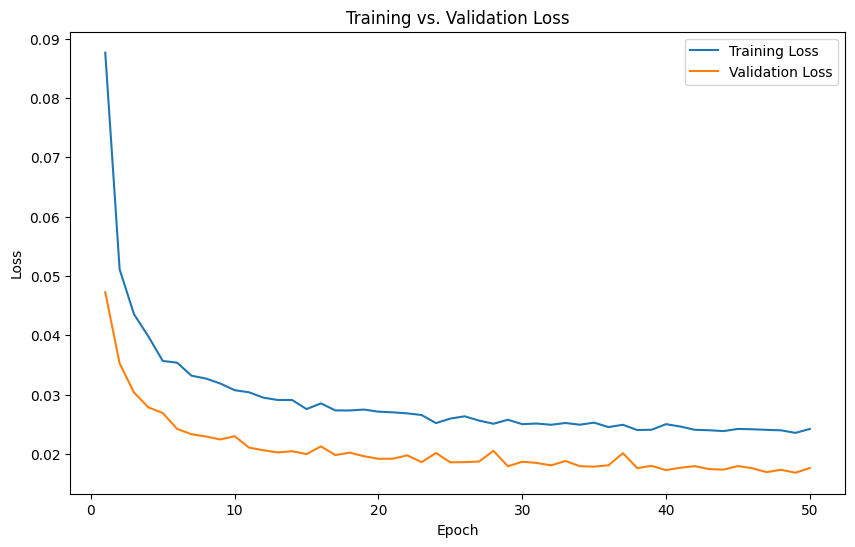

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

In [16]:
correct = 0
with torch.no_grad():
    for i, data in enumerate(X_test):
        # Forward pass
        y_val = model.forward(data.unsqueeze(0))  # Add batch dimension

        # Use Sigmoid to get probability if you're using a single output
        prob = torch.sigmoid(y_val).item()

        # Convert probability to class (0 or 1)
        predicted_class = 1 if prob >= 0.5 else 0

        # Check if the prediction matches the true label
        true_class = int(y_test[i].item())  # Convert true label to an integer
        if predicted_class == true_class:
            correct += 1

        # Print results
        print(f'{i+1}.) Predicted: {predicted_class}, True: {true_class}, Probability: {prob:.4f}')

# Calculate and print accuracy
accuracy = correct / len(X_test) * 100
print(f'\nCorrectly Classified: {correct}/{len(X_test)}')
print(f'Accuracy: {accuracy:.2f}%')

1.) Predicted: 1, True: 1, Probability: 1.0000
2.) Predicted: 1, True: 1, Probability: 1.0000
3.) Predicted: 0, True: 0, Probability: 0.0065
4.) Predicted: 1, True: 1, Probability: 0.9999
5.) Predicted: 1, True: 1, Probability: 0.7209
6.) Predicted: 0, True: 0, Probability: 0.0000
7.) Predicted: 0, True: 0, Probability: 0.1228
8.) Predicted: 0, True: 1, Probability: 0.0018
9.) Predicted: 0, True: 0, Probability: 0.0000
10.) Predicted: 0, True: 1, Probability: 0.0001
11.) Predicted: 0, True: 1, Probability: 0.4740
12.) Predicted: 0, True: 0, Probability: 0.0014
13.) Predicted: 1, True: 1, Probability: 0.9999
14.) Predicted: 1, True: 1, Probability: 0.9993
15.) Predicted: 1, True: 0, Probability: 0.9999
16.) Predicted: 0, True: 0, Probability: 0.0000
17.) Predicted: 0, True: 0, Probability: 0.0004
18.) Predicted: 0, True: 0, Probability: 0.0000
19.) Predicted: 0, True: 0, Probability: 0.0014
20.) Predicted: 1, True: 1, Probability: 1.0000
21.) Predicted: 1, True: 1, Probability: 1.0000
2

In [17]:
# predicting target attribute on testing dataset
model.eval()
with torch.no_grad():
	outputs = model(X_test)
	loss = criterion(outputs, y_test.unsqueeze(1))
	predictions = (torch.sigmoid(outputs) >= 0.5).float()
	accuracy = accuracy_score(y_test, predictions)
	print(f'Test results - Loss: {loss.item()} - Accuracy: {accuracy*100}%')

Test results - Loss: 0.9412701725959778 - Accuracy: 80.90844570617459%


Confusion Matrix:
[[9394  317]
 [3987 8846]]


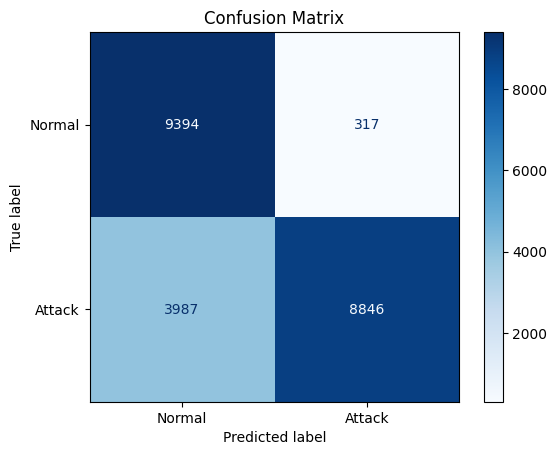

In [18]:
# Collect predictions and true labels
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for data, true_label in zip(X_test, y_test):
        # Forward pass
        y_val = model.forward(data.unsqueeze(0))  # Add batch dimension

        # Use Sigmoid for probability (for single output)
        prob = torch.sigmoid(y_val).item()

        # Convert probability to class
        predicted_class = 1 if prob >= 0.5 else 0

        # Append results
        all_predictions.append(predicted_class)
        all_true_labels.append(int(true_label.item()))

# Compute confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Attack"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

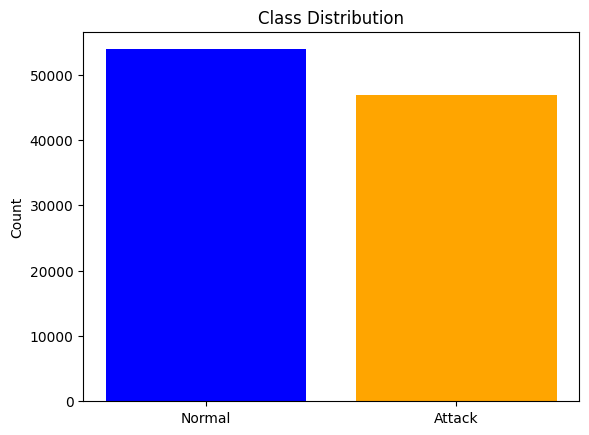

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Count occurrences of each class
class_counts = np.bincount(y_train.numpy().astype(int))

# Bar chart
plt.bar(["Normal", "Attack"], class_counts, color=["blue", "orange"])
plt.title("Class Distribution")
plt.ylabel("Count")
plt.show()

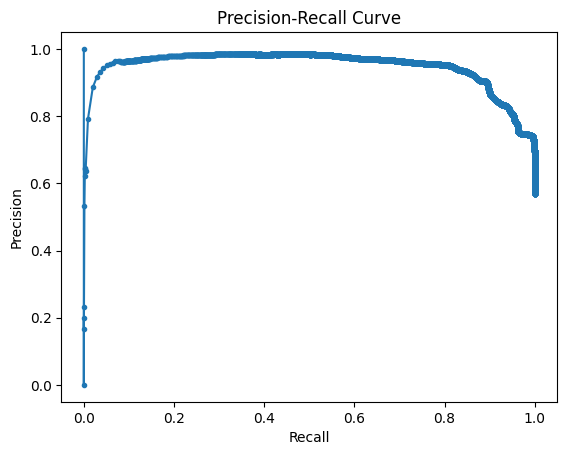

In [20]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

probs = model(X_test).sigmoid().squeeze().detach().numpy()
precision, recall, _ = precision_recall_curve(y_test.numpy(), probs)

plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


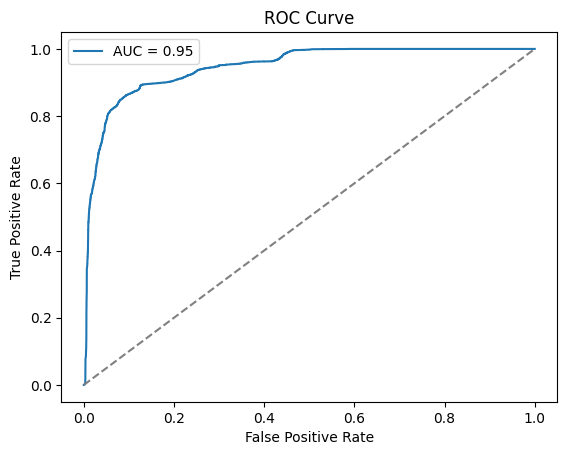

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test.numpy(), probs)
auc = roc_auc_score(y_test.numpy(), probs)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
